In [15]:
import torch
from torch import nn
from torch.utils.data import Dataset, dataloader
from torchvision.datasets import Flowers102
from torchvision.transforms import v2
from skimage import color
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device used : {device}")

device used : cuda


In [16]:
class CustomFlowersDataset(Dataset):
	def __init__(self, root, split="train", transform=None, download=False):
		self.flowers_dataset = Flowers102(root=root, split=split, download=download)
		self.transform = transform

	def __getitem__(self, index):
		image, _ = self.flowers_dataset[index]
		if self.transform is not None:
			image = self.transform(image)
		return image[0,...].unsqueeze(0), image

	def __len__(self):
		return len(self.flowers_dataset)


In [17]:
root_dir = "./ressources"

transform = v2.Compose([
	color.rgb2lab,
	v2.ToImage(),
	v2.ToDtype(torch.float32),
	v2.Resize((200,200), antialias=True),
])

train_dataset = CustomFlowersDataset(root=root_dir, split="train", transform=transform, download=True)
test_dataset = CustomFlowersDataset(root=root_dir, split="test", transform=transform, download=True)

Train dataset size: 1020
Test dataset size: 6149
Images shapes :torch.Size([1, 200, 200]) (input), torch.Size([3, 200, 200]) (target)


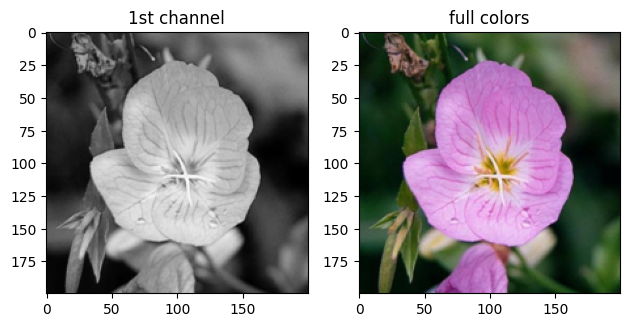

In [18]:
def tensorToImg(tensor:torch.Tensor):
	return tensor.moveaxis(0,2).detach().cpu().numpy()

print("Train dataset size:",len(train_dataset))
print("Test dataset size:",len(test_dataset))
img1, img2 = test_dataset[0]
print(f"Images shapes :{img1.shape} (input), {img2.shape} (target)")
fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2)
ax1.imshow(tensorToImg(img1), cmap="grey")
ax1.set_title("1st channel")
ax2.imshow(color.lab2rgb(tensorToImg(img2)))
ax2.set_title("full colors")
plt.tight_layout()

In [19]:
class ColorNN(nn.Module):
	def __init__(self, *args, **kwargs) -> None:
		super().__init__(*args, **kwargs)
		self.encoder = nn.Sequential(
			self.DoubleConv2d(1, 64),
			nn.MaxPool2d(2),
			self.DoubleConv2d(64, 128),
			nn.MaxPool2d(2),
			self.DoubleConv2d(128, 256),
			nn.MaxPool2d(2),
			self.DoubleConv2d(256, 512),
		)
		self.decoder = nn.Sequential(
			nn.ConvTranspose2d(512, 256, 2, 2),
			self.DoubleConv2d(256, 256),
			nn.ConvTranspose2d(256, 128, 2, 2),
			self.DoubleConv2d(128, 128),
			nn.ConvTranspose2d(128, 64, 2, 2),
			self.DoubleConv2d(64, 64),
		)
		self.final = nn.Conv2d(64, 3, 1)
	
	def forward(self, X):
		return self.final(self.decoder(self.encoder(X)))
		
	
	def DoubleConv2d(self, c_in, c_out, k_size=3):
		return nn.Sequential(
			nn.Conv2d(c_in, c_out, k_size, padding=1),
			nn.ReLU(),
			nn.Conv2d(c_out, c_out, k_size, padding=1),
			nn.ReLU()
		)

In [20]:
# Define the model
model = ColorNN().to(device)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Dataloaders
train_loader = dataloader.DataLoader(train_dataset, shuffle=True, batch_size=64)
test_loader = dataloader.DataLoader(test_dataset, shuffle=True, batch_size=64)

# Set the number of epochs
num_epochs = 10

# Training loop
def train_loop(dataloader, model, loss_fn, optimizer):
	size = len(dataloader.dataset)

	model.train()
	
	for batch, (X, y) in enumerate(dataloader):
		# Compute prediction and loss
		X = X.to(device)
		y = y.to(device)
		pred = model(X)
		loss = loss_fn(pred, y)

		# Backpropagation
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if batch % 10 == 0:
			loss, current = loss.item(), (batch + 1) * len(X)
			print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



In [21]:
train_acc = []
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, criterion, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 1186.165405  [   64/ 1020]
loss: 1223.886719  [  704/ 1020]
Epoch 2
-------------------------------
loss: 1294.096313  [   64/ 1020]
loss: 1202.859619  [  704/ 1020]
Epoch 3
-------------------------------
loss: 1275.959351  [   64/ 1020]
loss: 1312.603882  [  704/ 1020]
Epoch 4
-------------------------------
loss: 1116.114990  [   64/ 1020]
loss: 1295.160767  [  704/ 1020]
Epoch 5
-------------------------------
loss: 508.291779  [   64/ 1020]
loss: 1255.287476  [  704/ 1020]
Epoch 6
-------------------------------
loss: 1160.536377  [   64/ 1020]
loss: 714.063293  [  704/ 1020]
Epoch 7
-------------------------------
loss: 471.592377  [   64/ 1020]
loss: 455.526398  [  704/ 1020]
Epoch 8
-------------------------------
loss: 448.280670  [   64/ 1020]
loss: 466.259857  [  704/ 1020]
Epoch 9
-------------------------------
loss: 431.993408  [   64/ 1020]
loss: 455.408539  [  704/ 1020]
Epoch 10
-------------------------------
loss: 487.555

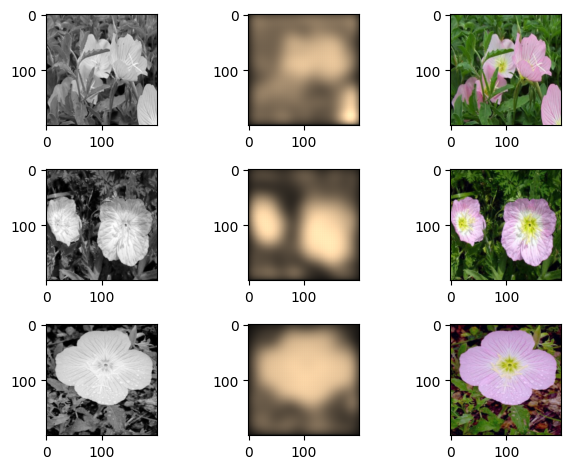

In [25]:
# ex_img = train_dataset[0][0][0,...].reshape(1, 200, 200)
# print(ex_img.shape)
# plt.imshow(ex_img.moveaxis(0, 2), cmap="grey")
# out = model(ex_img.to(device))
# print(out.detach().moveaxis(0, 2).shape)
# plt.figure()
# plt.imshow(color.lab2rgb(out.detach().moveaxis(0, 2).cpu()))
# plt.tight_layout()

fig = plt.figure()
axes = fig.subplots(3, 3)
for i, (ax1,ax2,ax3) in enumerate(axes):
	img1, img2 = train_dataset[i+6]
	out = model(img1.to(device))
	ax1.imshow(img1.moveaxis(0, 2), cmap="grey")
	ax2.imshow(color.lab2rgb(out.detach().moveaxis(0, 2).cpu()))
	ax3.imshow(color.lab2rgb(img2.moveaxis(0, 2).cpu()))

plt.tight_layout()